# Interpretable Clustering
## Using Decision Tree: binary classification problem = 1 if product is in the right cluster

0. boilerplate setting

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# Clustering Validation - silhouette_score, Calinski-Harabasz Index

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Clustering Method - Kmean, Hierarchical
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


In [8]:
# IMPORT: Tableau Superstore dataset
data_path = "../data/superstore_noid.csv"
df = pd.read_csv(data_path)
# CHANGE: to natural format: non-numeric types

# Type Change: 2 columns -> str
df['Customer ID'] = df['Customer ID'].astype("string")
df['Product ID'] = df['Product ID'].astype("string")

# Type Change: 5 columns -> category 
df['Ship Mode'] = df['Ship Mode'].astype("category")
df['Segment'] = df['Segment'].astype("category")
df['Region'] = df['Region'].astype("category")
df['Category'] = df['Category'].astype("category")
df['Sub-Category'] = df['Sub-Category'].astype("category")

# Type Change: 2 columns -> datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
# DEFINE: column types

id_columns = [
    "Customer ID", "Product ID",
]

# Potential target variables
numeric_columns = [
    "Sales", "Quantity", "Discount", "Profit"
]

category_columns = [
    "Ship Mode", #4
    "Segment", #3
    "Region", #4
    "Category", #3
    "Sub-Category" #17
]

void_columns = [
#    "Row ID", 
   "Order ID", "Country"
]

# Customer Name <-> Customer ID
# Product Name <-> Product ID
# [City, State, Postal Code] <-> Region
redundant_columns = [
    "Customer Name", "Product Name", 
    "City", "State", "Postal Code"
]
# ASSIGN: numeric id instead of string id
# Customer Id -> C_id
# Product Id -> P_id

for i in id_columns:
    df[i[0]+'_id'] = df.groupby(i).ngroup()
# DROP: 10 Columns = id + void + redundant
dropping_columns = id_columns + void_columns + redundant_columns

df_f = df.drop(columns=dropping_columns)
# PROFILE: exploratory analysis & save to HTML - uncomment when needed

# import ydata_profiling as yp

# report_super_f = df_f.profile_report()
# report_super_f.to_file(output_file="0409_super_f_report.html")

### 1. Interpreting Tung's clusters

### 2. Interpreting HJ's clusters

In [28]:
sales_099 = df[['Sales']].quantile(q=0.99, numeric_only=True, interpolation='linear')
sales_001 = df[['Sales']].quantile(q=0.01, numeric_only=True,interpolation='linear')

profit_099 = df[['Profit']].quantile(q=0.99, numeric_only=True,interpolation='linear')
profit_001 = df[['Profit']].quantile(q=0.01, numeric_only=True,interpolation='linear')

no_outlier_df = df[df['Sales']<float(sales_099)]
no_outlier_df = no_outlier_df[no_outlier_df['Sales']>float(sales_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']>float(profit_001)]
no_outlier_df = no_outlier_df[no_outlier_df['Profit']<float(profit_099)]

no_outlier_df= no_outlier_df.reset_index()
df_f = no_outlier_df.drop(columns=dropping_columns)

# ENCODE: One-Hot Encode 5 categorical variables
# "Ship Mode"#4 "Segment"#3 "Region"#4 "Category"#3 "Sub-Category"#17

for i in category_columns:
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(
        ohe.fit_transform(df_f[[i]]).toarray())
    # add suffix to column names in ohe_df
    ohe_df.columns = ohe_df.columns.astype(str)
    ohe_df = ohe_df.add_suffix(i)
    # define new dataframe to distinguish before-and-after encoding
    df_f = df_f.join(ohe_df)
# DROP & Standardize: categorical variables
df_f = df_f.drop(category_columns, axis=1)

# NORMALIZE
scaled_df_f = df_f.copy(deep=True)

scaler = MinMaxScaler()
scaled_df_f.iloc[:,[0]] = MinMaxScaler().fit_transform(df_f.iloc[:,[0]])
scaled_df_f.iloc[:,[1]] = MinMaxScaler().fit_transform(df_f.iloc[:,[1]])
scaled_df_f.iloc[:,[2]] = StandardScaler().fit_transform(df_f.iloc[:,[2]])
scaled_df_f.iloc[:,[3]] = StandardScaler().fit_transform(df_f.iloc[:,[3]])
scaled_df_f.iloc[:,[5]] = StandardScaler().fit_transform(df_f.iloc[:,[5]])
scaled_df_f.iloc[:,[6]] = MinMaxScaler().fit_transform(df_f.iloc[:,[6]])
scaled_df_f.iloc[:,[7]] = MinMaxScaler().fit_transform(df_f.iloc[:,[7]])

# perform PCA
pca_mle = PCA(n_components='mle', svd_solver='full')
pca_mle_df = pca_mle.fit_transform(scaled_df_f)
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=2023, perplexity=30)
tsne_df = tsne.fit_transform(scaled_df_f)

kmeans5 = KMeans(n_clusters=5, random_state=0)
kmeans5.fit(tsne_df)

product={}

for i in range(len(no_outlier_df)):
    if no_outlier_df['Product Name'][i] not in product:
        product[no_outlier_df['Product Name'][i]] = []
        product[no_outlier_df['Product Name'][i]].append(kmeans5.labels_[i])
    else:
        product[no_outlier_df['Product Name'][i]].append(kmeans5.labels_[i])

x_number = []
y_cluster = []
c_product = []
c_isitsame = []

c=0
for i in product:
    c=c+1
    for j in range(len(product[i])):
        #print(i, product[i][j], c)
        x_number.append(len(x_number)+1)
        y_cluster.append(product[i][j])
        c_product.append(c)
        c_isitsame.append(len(set(product[i]))<=1)

range_n_clusters = [4, 5, 6, 7, 8, 9, 10]
silhouette_avg = []
Calinski = []
clustering_score = []
Name = []

no_outlier_df = pd.read_pickle("0502_hj_no_outlier.pkl")

silhouette_avg.append([])
Calinski.append([])
clustering_score.append([])
Name.append('PCA-KMean')
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(pca_mle_df)

    # Add cluter label column for cluster interpretation via Decision Tree
    no_outlier_df['label_pca_km_{}'.format(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg[-1].append(silhouette_score(pca_mle_df, cluster_labels))
    Calinski[-1].append(metrics.calinski_harabasz_score(pca_mle_df, cluster_labels))

    product={}
    for i in range(len(no_outlier_df)):
        if no_outlier_df['Product Name'][i] not in product:
            product[no_outlier_df['Product Name'][i]] = []
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
        else:
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
    c = 0
    for i in product:
        c += (len(set(product[i]))<=1)
    clustering_score[-1].append(c/len(product))
    
    
silhouette_avg.append([])
Calinski.append([])
clustering_score.append([])
Name.append('PCA-Hierarchical')
for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    cluster_labels = clusterer.fit_predict(pca_mle_df)

    # Add cluter label column for cluster interpretation via Decision Tree
    no_outlier_df['label_pca_h_{}'.format(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg[-1].append(silhouette_score(pca_mle_df, cluster_labels))
    Calinski[-1].append(metrics.calinski_harabasz_score(pca_mle_df, cluster_labels))

    product={}
    for i in range(len(no_outlier_df)):
        if no_outlier_df['Product Name'][i] not in product:
            product[no_outlier_df['Product Name'][i]] = []
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
        else:
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
    c = 0
    for i in product:
        c += (len(set(product[i]))<=1)
    clustering_score[-1].append(c/len(product))


silhouette_avg.append([])
Calinski.append([])
clustering_score.append([])
Name.append('TSNE-KMean')
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(tsne_df)

    # Add cluter label column for cluster interpretation via Decision Tree
    no_outlier_df['label_tsne_km_{}'.format(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg[-1].append(silhouette_score(tsne_df, cluster_labels))
    Calinski[-1].append(metrics.calinski_harabasz_score(tsne_df, cluster_labels))

    product={}
    for i in range(len(no_outlier_df)):
        if no_outlier_df['Product Name'][i] not in product:
            product[no_outlier_df['Product Name'][i]] = []
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
        else:
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
    c = 0
    for i in product:
        c += (len(set(product[i]))<=1)
    clustering_score[-1].append(c/len(product))


silhouette_avg.append([])
Calinski.append([])
clustering_score.append([])
Name.append('TSNE-Hierarchical')
for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    cluster_labels = clusterer.fit_predict(tsne_df)

    # Add cluter label column for cluster interpretation via Decision Tree
    no_outlier_df['label_tsne_h_{}'.format(n_clusters)] = cluster_labels

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg[-1].append(silhouette_score(tsne_df, cluster_labels))
    Calinski[-1].append(metrics.calinski_harabasz_score(tsne_df, cluster_labels))

    product={}
    for i in range(len(no_outlier_df)):
        if no_outlier_df['Product Name'][i] not in product:
            product[no_outlier_df['Product Name'][i]] = []
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
        else:
            product[no_outlier_df['Product Name'][i]].append(clusterer.labels_[i])
    c = 0
    for i in product:
        c += (len(set(product[i]))<=1)
    clustering_score[-1].append(c/len(product))

/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/silmari/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
no_outlier_df.head()
no_outlier_df.to_pickle('0502_hj_nodf_cluster_labeled.pkl')

In [18]:
df_f.to_pickle('0502_hj_df_f.pkl')
no_outlier_df.to_pickle('0502_hj_no_outlier.pkl')
scaled_df_f.to_pickle('0502_hj_df_f_normalized.pkl')

In [20]:
no_outlier_df = no_outlier_df.drop(columns=dropping_columns)
no_outlier_df.to_pickle('0502_hj_no_outlier_dropped.pkl')

In [21]:
no_outlier_df.columns

Index(['index', 'Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Region',
       'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit',
       'C_id', 'P_id'],
      dtype='object')

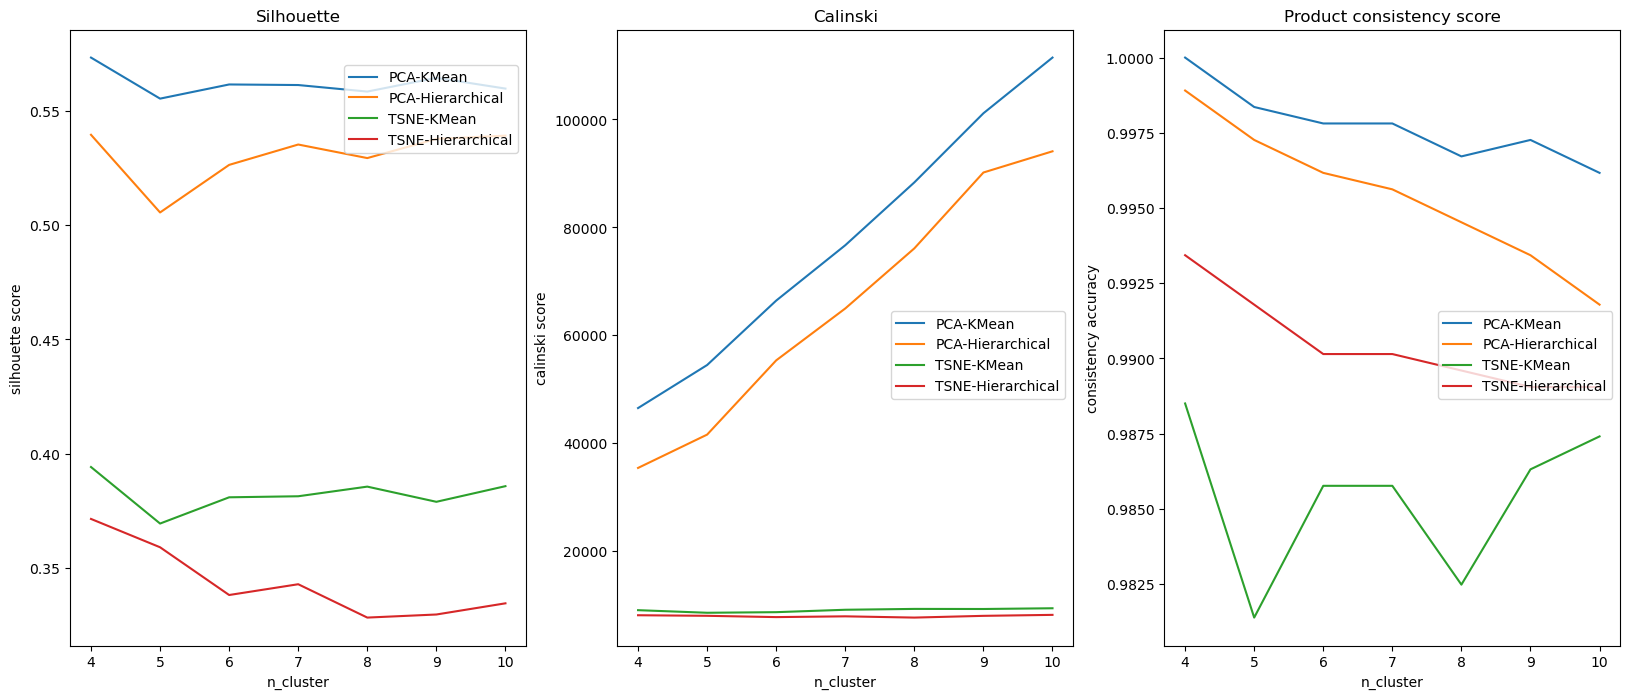

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
for i in range(len(silhouette_avg)):
    plt.plot(range_n_clusters, silhouette_avg[i], label = Name[i])
plt.title('Silhouette')
plt.xlabel('n_cluster')
plt.ylabel('silhouette score')
plt.legend(loc=(0.6, 0.8))

plt.subplot(1, 3, 2)
for i in range(len(Calinski)):
    plt.plot(range_n_clusters, Calinski[i], label = Name[i])
plt.title('Calinski')
plt.xlabel('n_cluster')
plt.ylabel('calinski score')
plt.legend(loc=(0.6, 0.4))


plt.subplot(1, 3, 3)
for i in range(len(clustering_score)):
    plt.plot(range_n_clusters, clustering_score[i], label = Name[i])
plt.title('Product consistency score')
plt.xlabel('n_cluster')
plt.ylabel('consistency accuracy')
plt.legend(loc=(0.6, 0.4))

plt.show()

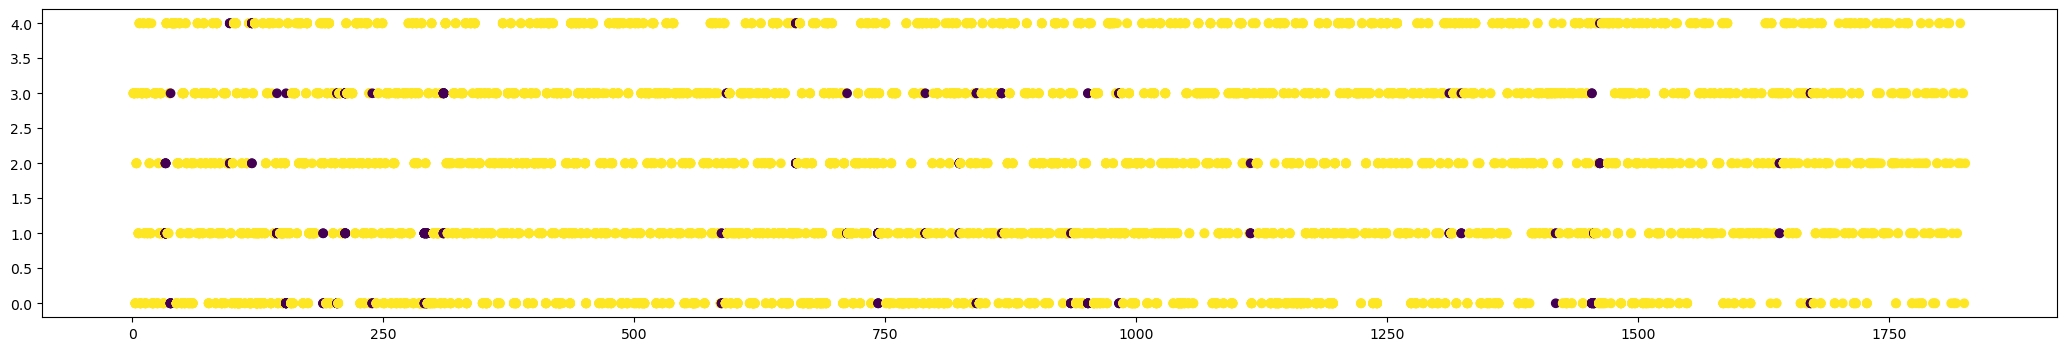

In [11]:
fig = plt.figure(figsize=(26,4))
plt.scatter(c_product, y_cluster, c=c_isitsame)
plt.show()

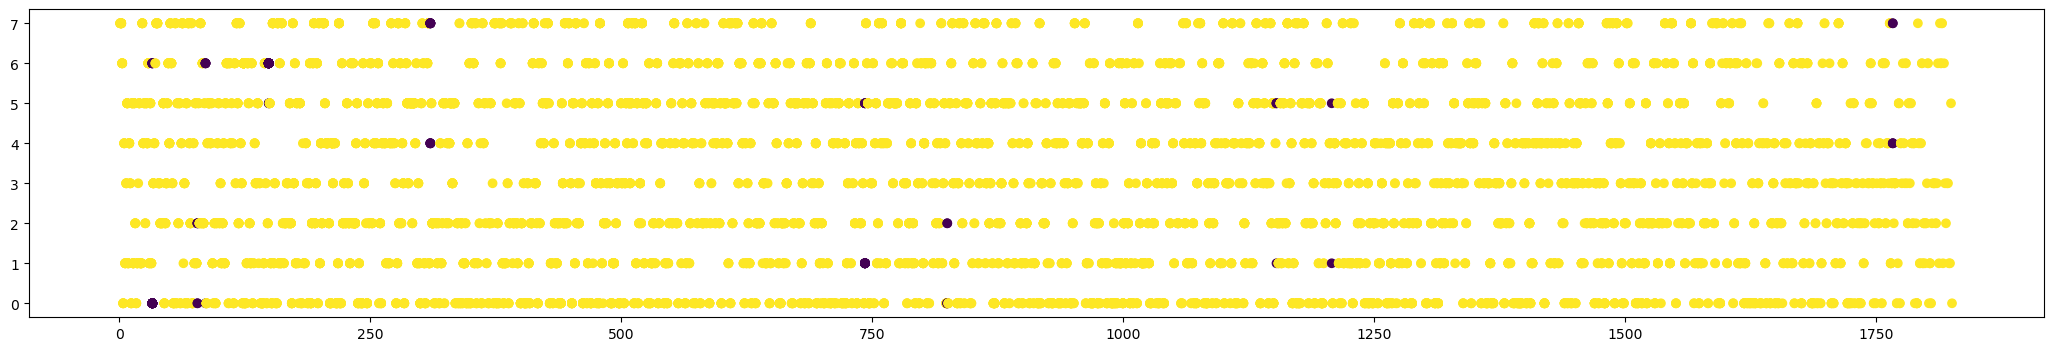

In [12]:
kmeans4 = AgglomerativeClustering(n_clusters=8, linkage="average")
kmeans4.fit(pca_mle_df)

product={}

for i in range(len(no_outlier_df)):
    if no_outlier_df['Product Name'][i] not in product:
        product[no_outlier_df['Product Name'][i]] = []
        product[no_outlier_df['Product Name'][i]].append(kmeans4.labels_[i])
    else:
        product[no_outlier_df['Product Name'][i]].append(kmeans4.labels_[i])

x_number = []
y_cluster = []
c_product = []
c_isitsame = []

c=0
for i in product:
    c=c+1
    for j in range(len(product[i])):
        #print(i, product[i][j], c)
        x_number.append(len(x_number)+1)
        y_cluster.append(product[i][j])
        c_product.append(c)
        c_isitsame.append(len(set(product[i]))<=1)


fig = plt.figure(figsize=(26,4))
plt.scatter(c_product, y_cluster, c=c_isitsame)
plt.show()

In [13]:
product

{'Bush Somerset Collection Bookcase': [7, 7, 7, 7],
 'Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back': [7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7],
 'Self-Adhesive Address Labels for Typewriters by Universal': [6,
  6,
  6,
  6,
  6,
  6,
  6],
 "Eldon Fold 'N Roll Cart System": [0, 0, 0, 0, 0],
 'Eldon Expressions Wood and Plastic Desk Accessories, Cherry Wood': [4,
  4,
  4,
  4,
  4],
 'Newell 322': [1, 1, 1, 1, 1, 1],
 'Mitel 5320 IP Phone VoIP phone': [3, 3, 3, 3],
 'DXL Angle-View Binders with Locking Rings by Samsill': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 'Belkin F5C206VTEL 6 Outlet Surge': [1, 1, 1, 1, 1, 1, 1],
 'Chromcraft Rectangular Conference Tables': [4, 4, 4, 4, 4, 4, 4, 4, 4],
 'Konftel 250 ConferenceÔøΩphoneÔøΩ- Charcoal black': [3, 3, 3, 3],
 'Xerox 1967': [0, 0, 0, 0, 0],
 'Fellowes PB200 Plastic Comb Binding Machine': [5, 5, 5, 5, 5, 5, 5, 5],
 'Holmes Replacement Filter for HEPA Air Cleaner, Very Large Room, HEPA Filter': [1,
  

In [14]:
no_outlier_df.columns

Index(['index', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'C_id',
       'P_id'],
      dtype='object')

In [19]:
scaled_df_f.columns

Index(['index', 'Order Date', 'Ship Date', 'Sales', 'Quantity', 'Discount',
       'Profit', 'C_id', 'P_id', '0Ship Mode', '1Ship Mode', '2Ship Mode',
       '3Ship Mode', '0Segment', '1Segment', '2Segment', '0Region', '1Region',
       '2Region', '3Region', '0Category', '1Category', '2Category',
       '0Sub-Category', '1Sub-Category', '2Sub-Category', '3Sub-Category',
       '4Sub-Category', '5Sub-Category', '6Sub-Category', '7Sub-Category',
       '8Sub-Category', '9Sub-Category', '10Sub-Category', '11Sub-Category',
       '12Sub-Category', '13Sub-Category', '14Sub-Category', '15Sub-Category',
       '16Sub-Category'],
      dtype='object')

In [31]:
no_outlier_df.shape
no_outlier_df.columns

Index(['index', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'C_id',
       'P_id', 'label_pca_km_4', 'label_pca_km_5', 'label_pca_km_6',
       'label_pca_km_7', 'label_pca_km_8', 'label_pca_km_9', 'label_pca_km_10',
       'label_pca_h_4', 'label_pca_h_5', 'label_pca_h_6', 'label_pca_h_7',
       'label_pca_h_8', 'label_pca_h_9', 'label_pca_h_10', 'label_tsne_km_4',
       'label_tsne_km_5', 'label_tsne_km_6', 'label_tsne_km_7',
       'label_tsne_km_8', 'label_tsne_km_9', 'label_tsne_km_10',
       'label_tsne_h_4', 'label_tsne_h_5', 'label_tsne_h_6', 'label_tsne_h_7',
       'label_tsne_h_8', 'label_tsne_h_9', 'label_tsne_h_10'],
      dtype='object')

In [16]:
df_f.shape

(9665, 40)

In [36]:
scaled_df_f.columns

Index(['index', 'Order Date', 'Ship Date', 'Sales', 'Quantity', 'Discount',
       'Profit', 'C_id', 'P_id', '0Ship Mode', '1Ship Mode', '2Ship Mode',
       '3Ship Mode', '0Segment', '1Segment', '2Segment', '0Region', '1Region',
       '2Region', '3Region', '0Category', '1Category', '2Category',
       '0Sub-Category', '1Sub-Category', '2Sub-Category', '3Sub-Category',
       '4Sub-Category', '5Sub-Category', '6Sub-Category', '7Sub-Category',
       '8Sub-Category', '9Sub-Category', '10Sub-Category', '11Sub-Category',
       '12Sub-Category', '13Sub-Category', '14Sub-Category', '15Sub-Category',
       '16Sub-Category'],
      dtype='object')

Accuracy: 1.0000


[Text(0.2857142857142857, 0.9, 'P_id <= 386.5\ngini = 0.799\nsamples = 7732\nvalue = [1534, 1318, 1671, 1602, 1607]\nclass = y[2]'),
 Text(0.14285714285714285, 0.7, 'gini = 0.0\nsamples = 1671\nvalue = [0, 0, 1671, 0, 0]\nclass = y[2]'),
 Text(0.42857142857142855, 0.7, 'P_id <= 754.5\ngini = 0.748\nsamples = 6061\nvalue = [1534, 1318, 0, 1602, 1607]\nclass = y[4]'),
 Text(0.2857142857142857, 0.5, 'gini = 0.0\nsamples = 1607\nvalue = [0, 0, 0, 0, 1607]\nclass = y[4]'),
 Text(0.5714285714285714, 0.5, 'P_id <= 1112.5\ngini = 0.664\nsamples = 4454\nvalue = [1534, 1318, 0, 1602, 0]\nclass = y[3]'),
 Text(0.42857142857142855, 0.3, 'gini = 0.0\nsamples = 1534\nvalue = [1534, 0, 0, 0, 0]\nclass = y[0]'),
 Text(0.7142857142857143, 0.3, 'P_id <= 1486.5\ngini = 0.495\nsamples = 2920\nvalue = [0, 1318, 0, 1602, 0]\nclass = y[3]'),
 Text(0.5714285714285714, 0.1, 'gini = 0.0\nsamples = 1602\nvalue = [0, 0, 0, 1602, 0]\nclass = y[3]'),
 Text(0.8571428571428571, 0.1, 'gini = 0.0\nsamples = 1318\nvalue

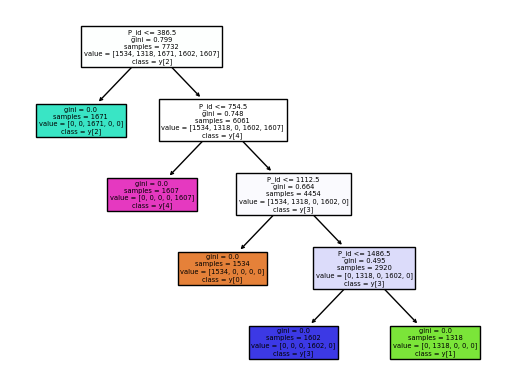

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
X = scaled_df_f
y = no_outlier_df['label_pca_km_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

plot_tree(dtc, feature_names = X.columns, filled = True, class_names=True)


Accuracy: 0.9995


[Text(0.6041666666666666, 0.9166666666666666, 'P_id <= 1040.5\ngini = 0.766\nsamples = 7732\nvalue = [2430, 1984, 1662, 769, 887]\nclass = y[0]'),
 Text(0.375, 0.75, 'P_id <= 619.5\ngini = 0.636\nsamples = 4534\nvalue = [1, 1984, 1662, 0, 887]\nclass = y[1]'),
 Text(0.16666666666666666, 0.5833333333333334, 'P_id <= 384.0\ngini = 0.453\nsamples = 2547\nvalue = [0, 0, 1662, 0, 885]\nclass = y[2]'),
 Text(0.08333333333333333, 0.4166666666666667, 'gini = 0.0\nsamples = 1662\nvalue = [0, 0, 1662, 0, 0]\nclass = y[2]'),
 Text(0.25, 0.4166666666666667, 'gini = 0.0\nsamples = 885\nvalue = [0, 0, 0, 0, 885]\nclass = y[4]'),
 Text(0.5833333333333334, 0.5833333333333334, 'P_id <= 621.5\ngini = 0.003\nsamples = 1987\nvalue = [1, 1984, 0, 0, 2]\nclass = y[1]'),
 Text(0.4166666666666667, 0.4166666666666667, '1Segment <= 0.5\ngini = 0.444\nsamples = 6\nvalue = [0, 4, 0, 0, 2]\nclass = y[1]'),
 Text(0.3333333333333333, 0.25, 'Profit <= 0.356\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 0, 0, 2]\nclass =

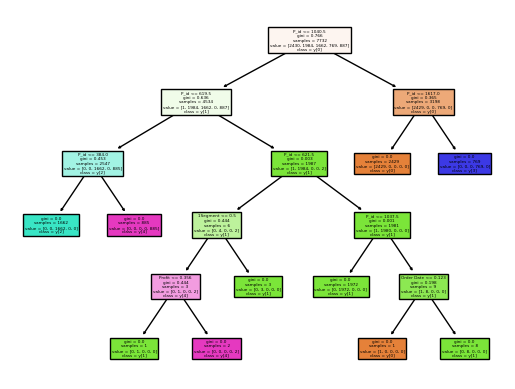

In [44]:
# PCA-H with cluster=5 hyperparameter
X = scaled_df_f
y = no_outlier_df['label_pca_h_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
plot_tree(dtc, feature_names = X.columns, filled = True, class_names=True)

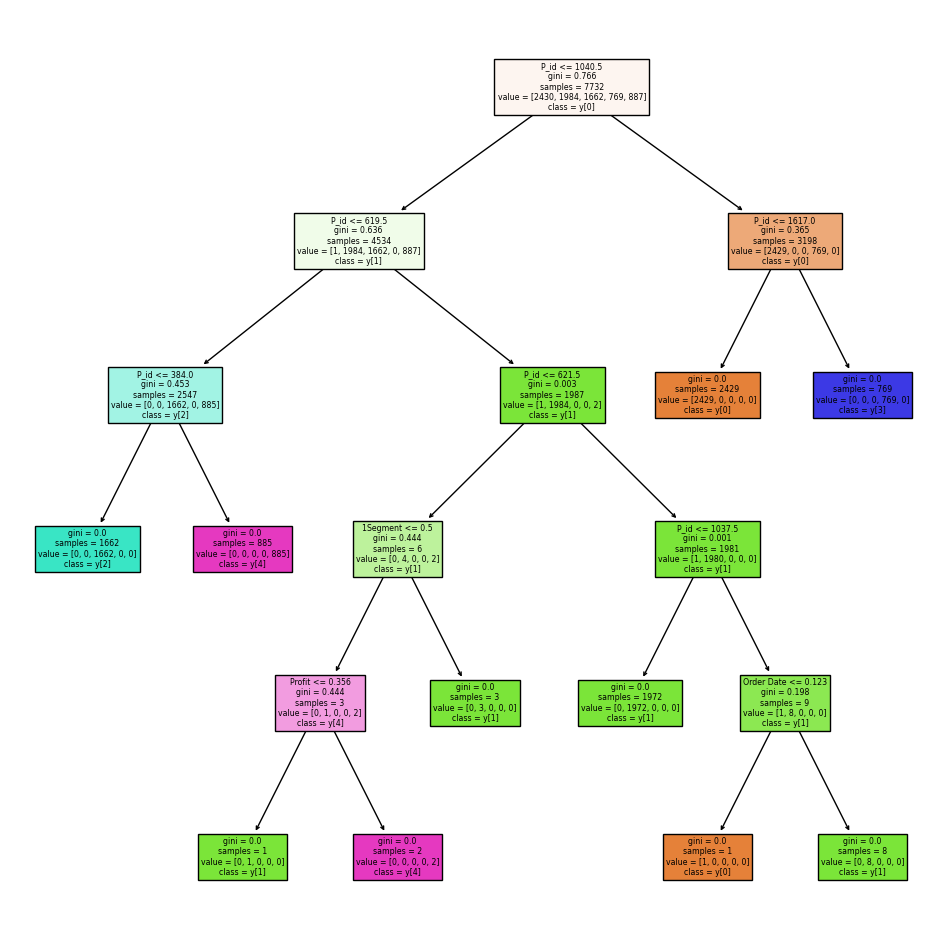

In [45]:
plt.figure(figsize=(12,12))
plot_tree(dtc, feature_names = X.columns, filled = True, class_names=True)
plt.show()

### 3. Interpreting the initial clusters